# Website and contributions

Github page https://github.com/luca2618/social_website

Website page: https://luca2618.github.io/social_website/

There are multiple pages use the next page at the bottom or the navbar.

Contribution statement

Main responsible:

Notebook
- Dataset formatting and cleaning - Lucas Emcken
- Network creation and weight function - Lucas Sylvester
- Network analysis - Lucas Sylvester + Lila
- Community detection - Lucas Sylvester
- Website
- Introduction - Lila
- Dataset - Lila + Lucas Emcken
- Network analysis - Lucas Sylvester
- Text analysis - Lucas Emcken

The git history is not representative of work done on the explainer notebook as it was made using Deep Note to work in unison in real time. The commits are representative of the work done on the website.

# Motivation

Beer has always played a pivotal role in Danish culture, serving as a beloved beverage, particularly among students. However, it not exactly clear what characterizes the types of beer people drink. Are people just more likely to drink what everybody else likes? or is there certain communities or archetypes of beer drinkers?
In response to this, we set out to research what beers people drink and the network that forms between people and beers linked by reviews. This might give insight into what types or groups of beer drinkers exists and what they like.


What kind of beer drinker are you? Are there different communities or archetypes of beer drinkers? These are some questions you might ask yourself. Through our website, we aim to answer these questions and provide insights into the network of beer enthusiasts.

We utilized a dataset from BeerAdvocate, which contains 1,586,259 reviews and 33,387 users. We discovered that the dataset provided a wealth of information. Thus we decided to only use a subset of it. 

# Basic stats

## Packages

In [3]:
import re
import networkx as nx
import pandas as pd
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus import wordnet as wn

from tqdm import tqdm
tqdm.pandas()

import sklearn.feature_extraction.text as sk_text
import tqdm

import wordcloud
import matplotlib.pyplot as plt

from PIL import Image


## The dataset

To investigate this we will be using the Beer Advocate dataset. Which a dataset stemming from an app collecting reviews of beer. The data span a period of more than 10 years, including all ~1.5 million reviews up to November 2011. Each review includes ratings in terms of five "aspects": appearance, aroma, palate, taste, and overall impression. We will main be focusing on the overall impression of the beer.

The dataset is quite comprehensive containing:
Number of reviews: 1,586,259
Number of users: 33,387
Number of beers:	66,051

Users with > 50 reviews : 4,787
Timespan: 10 years 



The dataset is available by request at https://snap.stanford.edu/data/web-BeerAdvocate.html 

The data was first formatted into a dataframe, but contains the original fields

### Text cleaning and preprocessing

Since the dataset contains the review scores and the review text, we first split them up to make processing faster, and to reduce memory requirements

In [ ]:
#read the data/beeradvocate.txt file

#read the first n reviews, max 1_586_259
reviews = []
review = []
n = 1_586_259//1
with open('beeradvocate.txt', encoding='latin-1') as f:
    for i in range(13*n + n -1):
        readline = f.readline().strip()
        #if the readline does not start with 'review/text'
        if readline[:11] != 'review/text':
            if readline == '':
                reviews.append(review)
                review = []
            else:
                #split the readline by ':'
                readline = readline.split(':')
                review.append(readline[1].strip())

#save the reviews to a pandas dataframe
reviews

columns = ['beer/name',
           'beer/beerId',
           'beer/brewerId',
           'beer/ABV',
           'beer/style',
           'review/appearance',
           'review/aroma',
           'review/palate',
           'review/taste',
           'review/overall',
           'review/time',
           'review/profileName',
           'review/text']
review_scores = pd.DataFrame(reviews, columns=columns[:-1])

#clear reviews and review
del reviews
del review

review_scores.to_parquet('data/review_scores.parquet', index=False, compression='gzip')


#read the first n reviews, max 1_586_259
wnl = WordNetLemmatizer()
reviews = []
review = []
n = 1_586_259
# n = 10
with open('beeradvocate.txt', encoding='latin-1') as f:
    # for i in range(13*n + n -1):
    j=0
    for i in tqdm(range(13*n + n -1)):
        readline = f.readline().strip()
        # print(readline)
        #if the readline does not start with 'review/text', 'review/beerId' or 'review/profileName'
        permit_readline = ['review/text', 'beer/beerId', 'review/profileName', 'beer/style']
        
        
        if any([readline[:len(permit)] == permit for permit in permit_readline]):
            
            j+=1
            
            #if its the review/text, remove stop words
            if readline[:11] == 'review/text':
                # print(readline)
                #split the readline by ':'
                readline = readline.split(':')
                reviewtext = readline[1]
                reviewtext = reviewtext.lower()
                reviewtext = reviewtext.split()
                #remove non-alphabetic characters
                reviewtext = [re.sub(r'[^a-zA-Z]', '', word) for word in reviewtext]

                #use numpy to remove stop words
                reviewtext = np.array(reviewtext)
                reviewtext = reviewtext[~np.isin(reviewtext, list(stop_words))]

                # reviewtext = np.array([ps.stem(word) for word in reviewtext])
                reviewtext = np.array([wnl.lemmatize(word) for word in reviewtext])
                                
                reviewtext = ' '.join(reviewtext)
                review.append(reviewtext)
            else:
                readline = readline.split(':')
                review.append(readline[1].strip())
            if j % 4 == 0:
                reviews.append(review)
                review = []

# print('convert reviews to dataframe')
# reviews
review_texts = pd.DataFrame(reviews, columns=['beer/beerId', 'review/profileName', 'beer/style', 'review/text'])

review_texts.to_parquet('data/review_texts_lemmatized.parquet', index=False, compression='gzip')

del reviews
del review

In [4]:
df = pd.read_parquet("review_scores.parquet")
df

beer/name beer/beerId beer/brewerId beer/ABV  \
0                          Sausa Weizen       47986         10325     5.00   
1                              Red Moon       48213         10325     6.20   
2                Black Horse Black Beer       48215         10325     6.50   
3                            Sausa Pils       47969         10325     5.00   
4                         Cauldron DIPA       64883          1075     7.70   
...                                 ...         ...           ...      ...   
1586253     Otto Mulligan's Irish Stout       20810         10434     4.80   
1586254                Rock Allotolager       20840         10434     4.50   
1586255         Spencer Creek Amber Ale       43816         10434     5.50   
1586256  Screamin' Eagle American Lager       26179         10434     4.30   
1586257              Henley HayFeweizen       20812         10434     4.10   

                             beer/style review/appearance review/aroma  \
0                            Hefeweizen               2.5            2   
1                    English Strong Ale                 3          2.5   
2                Foreign / Export Stout                 3          2.5   
3                       German Pilsener               3.5            3   
4        American Double / Imperial IPA                 4          4.5   
...                                 ...               ...          ...   
1586253                 Irish Dry Stout                 4          3.5   
1586254                  Czech Pilsener               4.5          3.5   
1586255        American Amber / Red Ale               3.5            4   
1586256             American Pale Lager                 4          3.5   
1586257         American Pale Wheat Ale               4.5          3.5   

        review/palate review/taste review/overall review/time  \
0                 1.5          1.5            1.5  1234817823   
1                   3            3              3  1235915097   
2                   3            3              3  1235916604   
3                 2.5            3              3  1234725145   
4                   4          4.5              4  1293735206   
...               ...          ...            ...         ...   
1586253             4            4              4  1100820088   
1586254           3.5          4.5              5  1100921182   
1586255           4.5            4            4.5  1216431050   
1586256           3.5          3.5            3.5  1128463408   
1586257             4            4            4.5  1100825167   

        review/profileName  
0                  stcules  
1                  stcules  
2                  stcules  
3                  stcules  
4           johnmichaelsen  
...                    ...  
1586253         RedDiamond  
1586254         RedDiamond  
1586255         RedDiamond  
1586256         RedDiamond  
1586257         RedDiamond  

[1586258 rows x 12 columns]

To simplify network construction, we only want unique beer reviews from each person. If a person has more than review of a beer it keep the latest review of that beer. 

In [5]:
df = df.sort_values("review/time", ascending=False)
df = df.drop_duplicates(subset=['review/profileName', 'beer/name'], keep='first')
print("Number of reviews in the dataset")
print(len(df)) 

Number of reviews in the dataset
1560428


## Constructing the network

To scope the project and limit the amount of data in the network, we have chosen to work with casual beer drinker/reviewer. Some of the reviewers in the dataset are quite extreme some even having 5000+ reviews, and while there certainly are place for people drinking that much beer, we have elected to focus on what most people can relate to in beer. To do this we have selected people in the dataset that have 10-100 beer reviews.

In [6]:
def def_value(): 
    return 0
review_count = defaultdict(def_value)
for person in df["review/profileName"]:
    review_count[person] = review_count[person]+1
review_count[""] = 0

people = set()

for person,count in review_count.items():
    if (10<count and count<100):
        people.add(person)
print("Stats of the selected data subset")
print("Number of people:")
print(len(people))

df = df[df['review/profileName'].isin(people)].reset_index()
print("Number of reviews:")
print(len(df))

Stats of the selected data subset
Number of people:
7041
Number of reviews:
241844


To construct our network initially create a bipartite network of people and beers, connected by the reviews that the people have made of the corresponding beer.

In [7]:
G_bi = nx.Graph()
#add the nodes of the selected people
G_bi.add_nodes_from(people, bipartite=0)

Add the edges if the review is from a relevant person

In [8]:
beers = set()
for i in range(len(df)):
    if df["review/profileName"][i] in people:
        G_bi.add_edge(df["beer/name"][i], df["review/profileName"][i], score=df["review/overall"][i])
        beers.add(df["beer/name"][i])

Since we expect our network to be quite interconnected, we want our network to represent more than just if 2 people share the beer. To do this we have decided to do a weighted network and base the weight on a relatedness score based on the beers the 2 people have reviewed and how they liked them. The weight is determined by the sum of a compatability score for each shared beer the 2 people have reviwed.

To determine compatibility of 2 beer reviews, we compute the difference in overall ratings, which can vary from 0 to 4 in half point increments. We then assign a compatibility grade based on this difference: if the difference is 0, the compatibility grade is 1, indicating total agreement.

 Conversely, if the difference is 4, the compatibility grade is -1, signifying complete disagreement."This version streamlines the explanation of your methods and highlights the relevance of the overall rating in assessing user compatibility.

This should create a weighted network where people who have mainly opposite opinions of the beer that they both drink have a negative weight and people who agree have a positive weight. Further more the more beers and the more they agree/disagree, the weight will be numerically larger.

In [9]:
def beer_weight_function(G, u, v):
            u_weight = dict(G[u])
            v_weight = dict(G[v])
            u_beers = set(u_weight.keys())
            v_beers = set(v_weight.keys())
            common = u_beers.intersection(v_beers)
            weight = 0
            for beer in common:
                difference = abs(float(u_weight[beer]["score"])-float(v_weight[beer]["score"]))
                weight += 1 - 2 * (difference / 5)
            return weight

Lastly to create a network of people and their reviews, we project the bipartite graph onto the people nodes and weight the connection of people with shared beers with the previously explained weight function. We also remove the beer nodes as they are no longer relevant. (They are still present as isolated nodes).

In [10]:
G = bipartite.generic_weighted_projected_graph(G_bi, people, beer_weight_function)
G.remove_nodes_from(beers)


# Tools, theory and analysis

## Network analysis

In [ ]:
print("1. Network metrics")
print(f"Total number of nodes: {len(G.nodes)}, total number of links: {len(G.edges)}")
density = nx.density(G)
print(f"Network density: {np.round(density,7)}, {np.round((density)*100, 2)}% of all possible links are present.")
print(f"The network is connected: {nx.is_connected(G)}")
print(f"The network has {nx.number_connected_components(G)} connected components.")
print(f"The size of the largest connected component: {len(max(nx.connected_components(G), key=len))}")
print(f"The networks has {len(list(nx.isolates(G)))} isolated nodes.")

1. Network metrics
Total number of nodes: 7038, total number of links: 10055635
Network density: 0.4060717, 40.61% of all possible links are present.
The network is connected: True
The network has 1 connected components.
The size of the largest connected component: 7038
The networks has 0 isolated nodes.


The network is fully connected, meaning there is at least one path between any two nodes within the network. This implies a strong level of interconnectedness and interaction among all beer drinkers in the dataset.

Furthermore, the network consists of a single connected component, confirming that all nodes are part of the same giant cluster and that there are no isolated groups or outliers.

The density of our network is really high, 40,61%. 

 The high connectivity and density suggest that the community of beer drinkers in your dataset is very interactive, with many users sharing opinions on the same beers. 

This can be indicative of a strong social aspect within the community where users are possibly influenced by each other's tastes and opinions.

Such a network is ideal for developing recommendation systems. Given the high interaction, algorithms can effectively predict and suggest beers to users based on the preferences of similar users within the network.

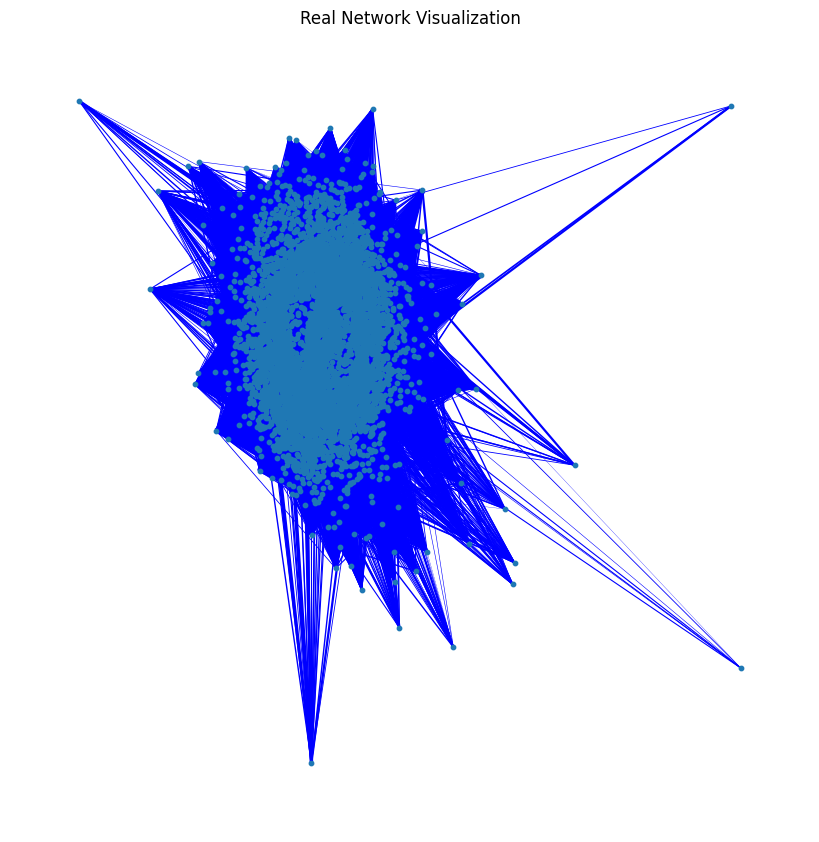

In [ ]:
plt.figure(figsize=(8, 8))
edge_widths = [w for (*edge, w) in G.edges.data('weight')]
nx.draw(G, node_size=10, edge_color="blue", with_labels=False, width=edge_widths)
plt.title("Real Network Visualization")
plt.show()

In [ ]:
print("2. Degree analysis")
avg_degree = np.mean(list(dict(G.degree()).values()))
avg_degree = np.round(avg_degree, 2)
median_degree = np.median(list(dict(G.degree()).values()))
minimum_degree = min(dict(G.degree()).values())
maximum_degree = max(dict(G.degree()).values())
print(f"Average degree: {avg_degree}, median degree: {median_degree}, minimum degree: {minimum_degree}, maximum degree: {maximum_degree}")

2. Degree analysis
Average degree: 2857.53, median degree: 2735.0, minimum degree: 4, maximum degree: 6171


The degree of a node in a network represents the number of connections or links that node has with other nodes. 

Considering the total number of nodes (7038), we have a very high average degree, which means that each beer drinker has reviewed beers that on average 2857 other drinkers also reviewed. Furthermore, the median degree show that the degree distribution is quite uniform and most drinker have a similar level of activity in terms of the number of shared reviews. 

The minimum degree is significantly lower than the average indicating that there are a just a few drinkers with very few connections.  

### Random network

To create a baseline for the distribution of degrees in the network we create a random network to compare. We created the random network with the same probability of 2 nodes being linked and the same amount of nodes. Resulting in a similar average degree.

In [11]:
N = G.number_of_nodes ()
L = G.number_of_edges()
#substituting p out of the formula
p = 2*L/(N*(N-1))
print("p: ", np.round(p, 7))

#average degrees
k = p * (N-1)
print(f"Average degree of random network with this probability: {np.round(k, 3)}")

#generate random graph
def generate_random_g (N,p): 
    G = np.random.uniform(size=(N, N)) < p
    for i in range(N): #remove probabilities to connecto itself, and dont sample probability twice.
        G[i,i:N] = 0
    #append pairs that are true in G
    edges = np.array(np.where(G)).T
    print(f"Number of edges: {len(edges)}")

    #make a graph 
    graph = nx.Graph()
    graph.add_edges_from(edges)
    return graph 

random_network = generate_random_g (N,p)


p:  0.4060717
Average degree of random network with this probability: 2857.526
Number of edges: 10056446


Plotting the distribution of the random network on top of the true one, we can see that are much more variability in the degree of nodes in the real network compared to the random one. Meaning that the real network represent a larger interval of bears drinker that have fewer or larger sets of shared beers.

2857.5262858766696
2857.5041204887752


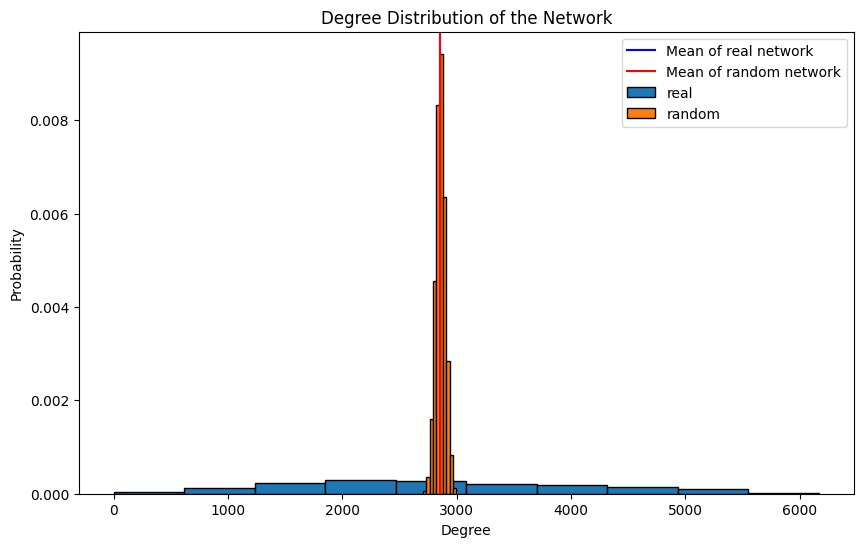

2857.5262858766696


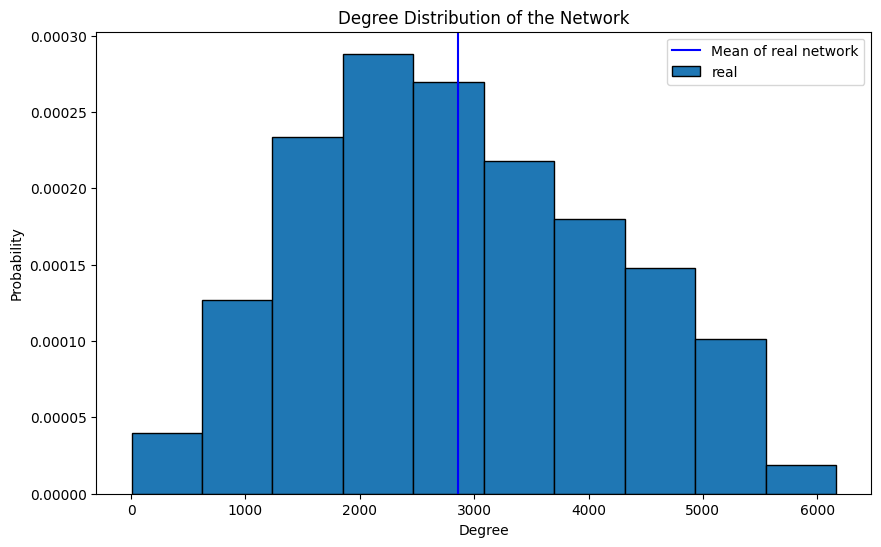

In [ ]:
# compute the distribution of degree Random 
def compute_degree_distribution(network, log=False):
    # Extract the degree sequence
    degrees = [degree for node, degree in network.degree() if degree != 0]
    print(np.mean(degrees))
    # Compute the histogram of the degree distribution
    max_degree = max(degrees)
    #choose if bins are on a log scale.
    if log:
        #bins = np.geomspace(1, max_degree + 2,4)
        bins = np.geomspace(min(degrees), max_degree*10,10)
    else:
        bins = np.arange(min(degrees), max_degree + 2, int((max_degree-min(degrees))/10))
    hist, edges = np.histogram(degrees, bins=bins, density=True)
    
    return hist, edges, degrees

#compute the 
def plot_degree_distribution(hist, edges, degrees, title="Degree Distribution", name = "random", col="b"):
    # Plot the degree distribution
    plt.bar(edges[:-1], hist, width=np.diff(edges), edgecolor='black', align='edge', label=name)
    #plt.loglog(edges[:-1] + 0.5, hist, label = "Distribution of "+name+" network")
    #plt.log(edges[:-1] + 0.5, hist, label = "Distribution of "+name+" network")
    plt.title(title)
    plt.xlabel("Degree")
    plt.ylabel("Probability")

    plt.axvline(x = np.mean(degrees), color=col, label = 'Mean of '+name+' network')
    plt.legend()
    #plt.savefig("img/"+title+".png")
    


plt.figure(figsize=(10, 6))
hist, edges, degrees = compute_degree_distribution(G, log=False)  # Use your network variable here
plot_degree_distribution(hist, edges, degrees, title="Degree Distribution of the Network", name="real")
hist, edges, degrees = compute_degree_distribution(random_network, log=False)  # Use your network variable here
plot_degree_distribution(hist, edges, degrees, title="Degree Distribution of the Network", name="random", col="r")

plt.legend()
plt.show()
plt.figure(figsize=(10, 6))
hist, edges, degrees = compute_degree_distribution(G, log=False)  # Use your network variable here
plot_degree_distribution(hist, edges, degrees, title="Degree Distribution of the Network", name="real")
plt.legend()
plt.show()

In [ ]:
# Calculate degree assortativity
degree_assortativity = nx.degree_assortativity_coefficient(G)
print(f"Degree Assortativity Coefficient: {degree_assortativity}")

Degree Assortativity Coefficient: -0.10450255272761652


Our degree assortativity coefficient is  approximately -0.1045. As the coefficient is around zero, it suggests a random mixing pattern of degree. However, it still negative, which show that high degree node are slightly more likely to connect to low degree node (users who share reviews with fewer users). This could suggest that people who have only reviewed fewer or less popular beer are more likely to have at least one beer in common with a person who has more reviews / reviews of more popular beers, which makes sense.

1.453527837873988


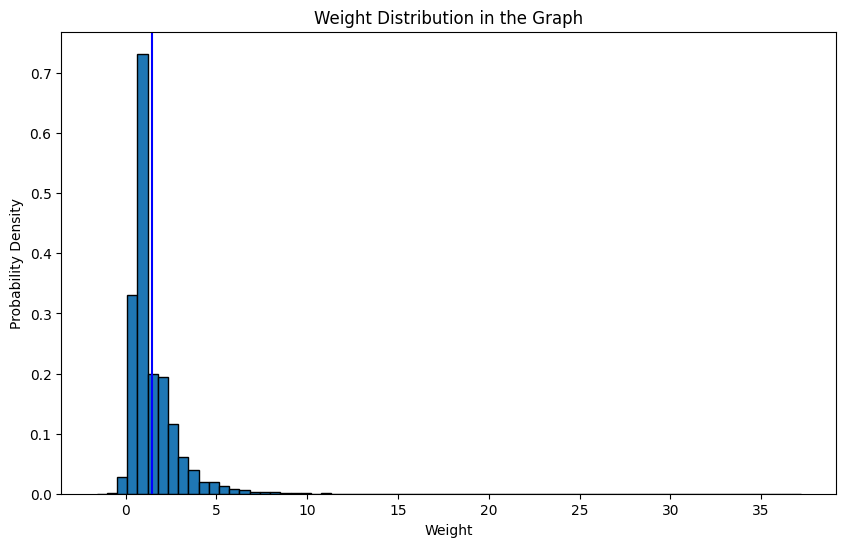

In [12]:
# compute weight 
def compute_weight_distribution(graph):
    # Create a list of weights
    weights = [data['weight'] for u, v, data in graph.edges(data=True) if 'weight' in data]
    print(np.mean(weights))
    # Compute the histogram of weights
    weight_bins = np.linspace(min(weights), max(weights), num=70)  # Adjust the number of bins as needed
    hist, edges = np.histogram(weights, bins=weight_bins, density=True)
    mean = np.mean(weights)
    return hist, edges, mean

hist, edges, mean = compute_weight_distribution(G)


def plot_weight_distribution(hist, edges, mean, title='Weight Distribution in the Graph'):
    # Plot the distribution
    plt.figure(figsize=(10, 6))
    plt.bar(edges[:-1], hist, width=np.diff(edges), edgecolor='black', align='edge')
    plt.title(title)
    plt.xlabel('Weight')
    plt.ylabel('Probability Density')
    plt.axvline(x = mean, color="blue", label = 'Mean of network weights')
    plt.savefig("test.png")
    plt.show()

plot_weight_distribution(hist,edges, mean)



With an average weight of around 1.5, we can see that people on average either or somewhere in between completely agree on 1.5 beers on slightly agree on several. This align with people at most having shared a few beers if any. Furthermore, we see very few negative weights. This is expected as we mostly expect people to, 1. like the beers that they drink 2. agree on ling the same beers if they reviews them.

### Community detection using weighted graph

In [ ]:
communities = nx.community.greedy_modularity_communities(G, weight="weight")
print("nr of found communnities: "+str(len(communities)))
for i, community in enumerate(communities):
    print("community "+str(i)+" size: " + str(len(community)))

nr of found communnities: 3
community 0 size: 3518
community 1 size: 3466
community 2 size: 54


In [ ]:
community_map = {person: i for i, community in enumerate(communities) for person in community}
df['community'] = df['review/profileName'].apply(lambda person: community_map.get(person) if person in community_map else "NAN")

## Textual analysis

In [ ]:
reviews = pd.read_parquet('review_texts_lemmatized.parquet')
reviews.columns = ['beer/beerId', 'beer/style', 'review/profileName', 'review/text']
scores = pd.read_parquet('review_scores.parquet')
reviews['beer/style'] = scores['beer/style']
reviews['review/overall'] = scores['review/overall']
reviews['beer/name'] = scores['beer/name']

#split reviews into communities
community_reviews = []

for community in communities:
    community_reviews.append(reviews[reviews['review/profileName'].isin(community)])

#add a community column to each dataframe
for i, community in enumerate(community_reviews):
    community['community'] = i

#combine community reviews into one dataframe with a column for the community
community_reviews = pd.concat(community_reviews)

#remove reviews with a lower score than 4
community_reviews['review/overall'] = community_reviews['review/overall'].astype(float)
community_reviews = community_reviews[community_reviews['review/overall'] >= 4]

In [ ]:
#create TF-IDF for each community
tfid = sk_text.TfidfVectorizer(stop_words='english', max_features=1000)

reviews_by_community = community_reviews.groupby('community')['review/text'].apply(lambda x: ' '.join(x))
tfid.fit(reviews_by_community)
transformed = tfid.transform(reviews_by_community)

#calculate the TF for each community
tf = transformed.sum(axis=1)
tf = np.array(tf).flatten()
tf = np.array(tf)
tf = tf / np.sum(tf)

ignore_words = set(['like', 'one','two', 'good','nice','little','great', 'overall','color'])

adjectives = set()
for synset in list(wn.all_synsets('a')):
    for lemma in synset.lemmas():
        adjectives.add(lemma.name())

#calculate the TF-IDF for each community
community_tfidf = {}

for i, community in enumerate(tqdm.tqdm(reviews_by_community.index)):
    TFIDF = {}
    indices = np.argsort(transformed[i].toarray().flatten())[::-1]
    feature_names = tfid.get_feature_names_out()
    for j in indices:
        word = feature_names[j]
        
        if word in adjectives and word not in ignore_words:
            TFIDF[word] = transformed[i].toarray().flatten()[j] * tf[i]
            if len(TFIDF) == 100:
                break
    community_tfidf[community] = TFIDF


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
100%|██████████| 3/3 [00:00<00:00, 135.51it/s]


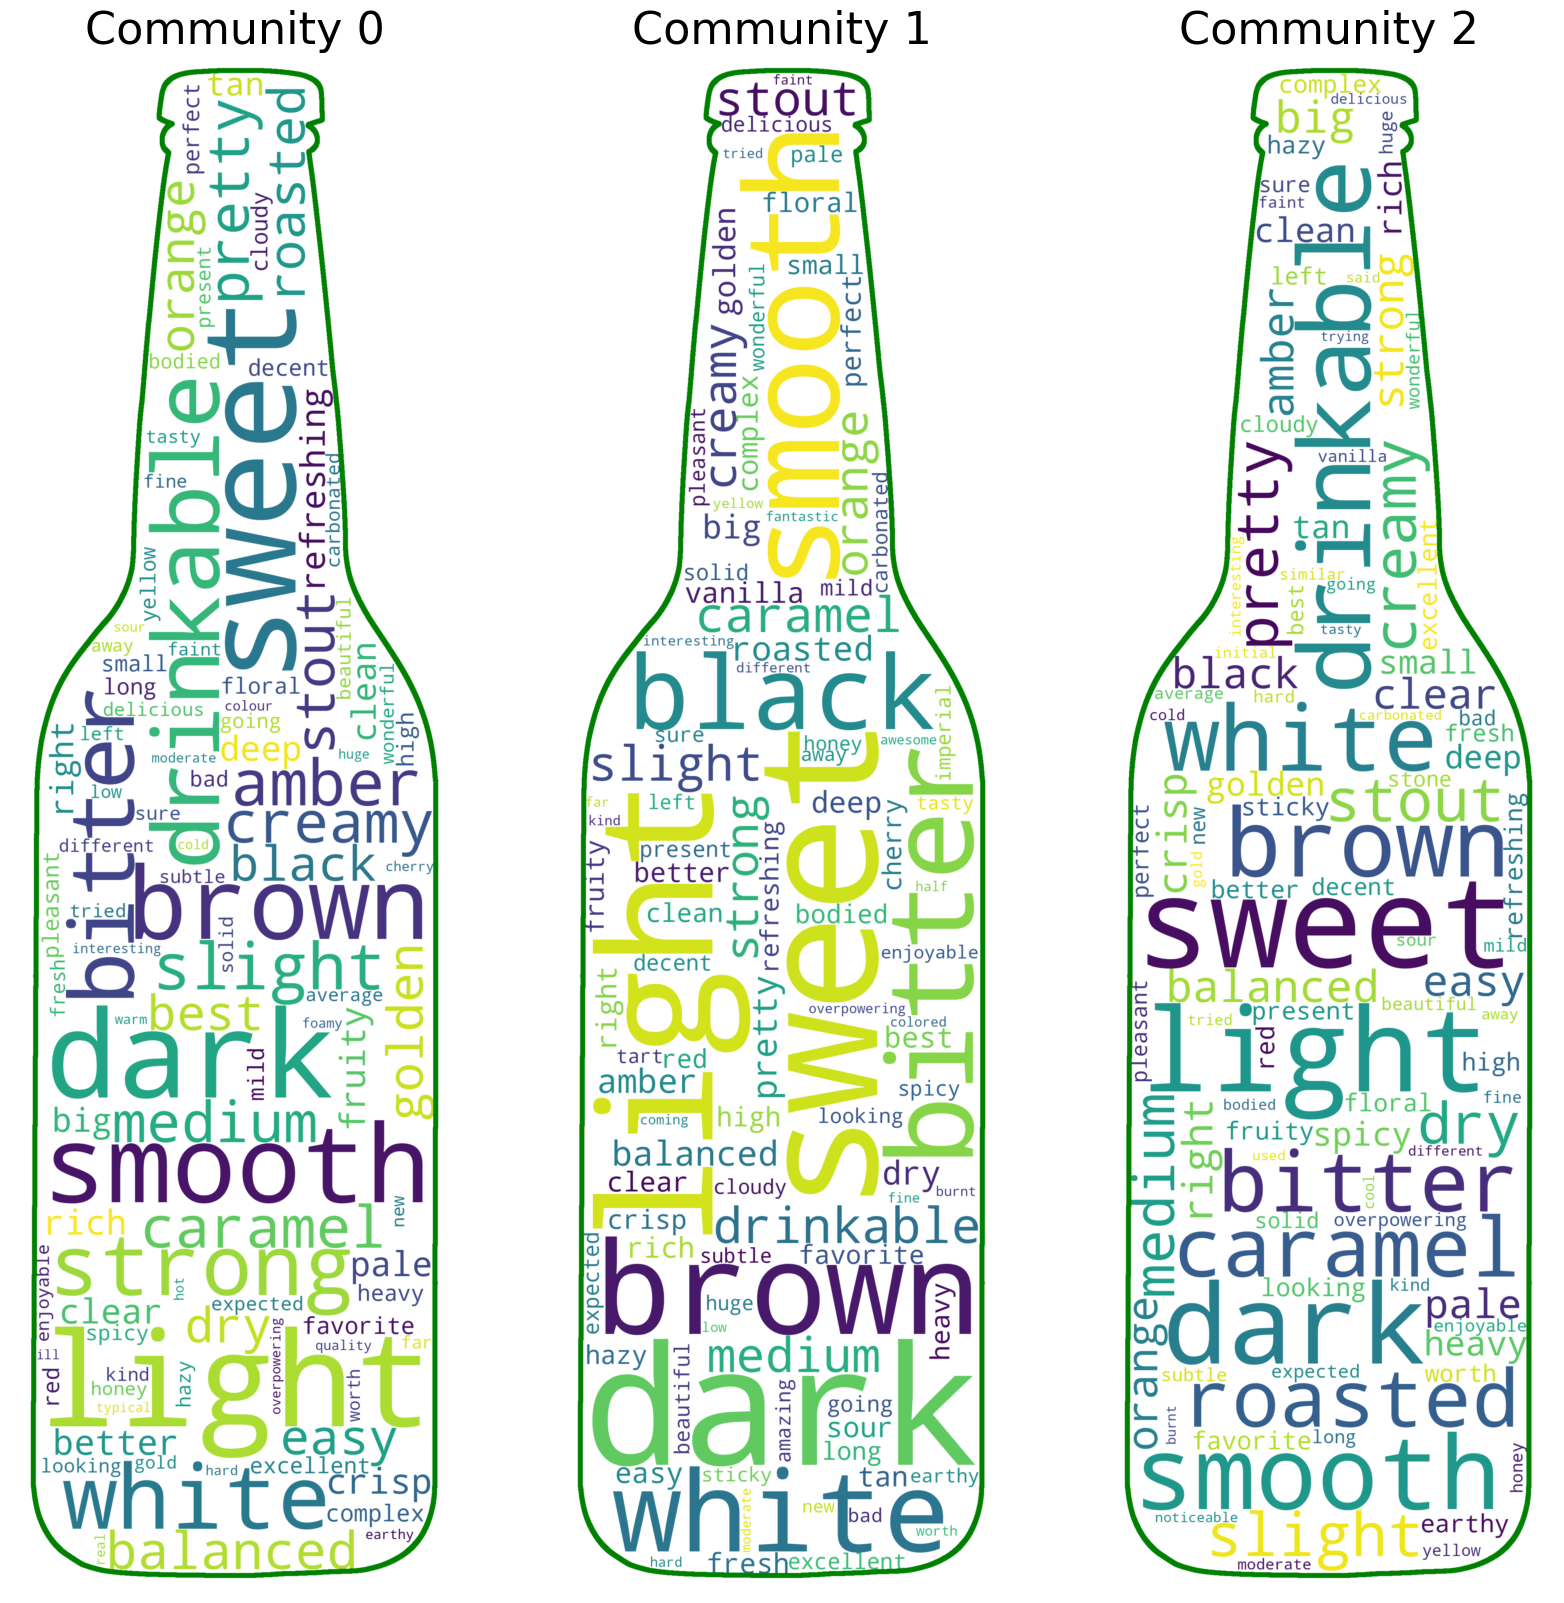

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))

beer_mask = np.array(Image.open("beer.png"))

for i, community in enumerate(community_tfidf):
    wc = wordcloud.WordCloud(background_color="white",
                            max_words=250, 
                            mask=beer_mask,
                            contour_color='green',
                            contour_width=25,
                            scale=1)
    wc.generate_from_frequencies(community_tfidf[community])
    ax[i].imshow(wc, interpolation='bilinear')
    ax[i].axis("off")
    ax[i].imshow(beer_mask, cmap=plt.cm.gray, alpha=0.0)
    ax[i].set_title('Community ' + str(i), fontsize=32, color='black')

plt.show()

### Top beers within community

In [ ]:
#split community reviews into communities
community_reviews = []

for community in communities:
    community_reviews.append(reviews[reviews['review/profileName'].isin(community)])
    

#remove beers with less than 10 within each community
top_beers_by_community = {}
temp_community_reviews = community_reviews.copy()
for i, community in enumerate(temp_community_reviews):
    temp_community_reviews[i] = temp_community_reviews[i].groupby('beer/beerId').filter(lambda x: len(x) >= 10)
    #convert the column to float
    temp_community_reviews[i]['review/overall'] = temp_community_reviews[i]['review/overall'].astype(float)
    

    # top beers by average score
    top_beers = temp_community_reviews[i].groupby('beer/beerId')['review/overall'].mean().sort_values(ascending=False)
    
    #Rank the top beers by number of reviews
    #set all reviews to 1
    #temp_community_reviews[i]['review/overall'] = 1
    
    #top_beers = temp_community_reviews[i].groupby('beer/beerId')['review/overall'].sum().sort_values(ascending=False)
    
    
    top_beers_by_community[i] = top_beers

#calculate the TF-IDF for each top 3 beers in each community
top_beer_tfidf = {}

for i, beers in enumerate(tqdm.tqdm(top_beers_by_community)):
    for j, beer in enumerate(top_beers_by_community[beers].index[:3]):
        beer_reviews = temp_community_reviews[i][temp_community_reviews[i]['beer/beerId'] == beer]
        reviews_by_beer = beer_reviews.groupby('beer/beerId')['review/text'].apply(lambda x: ' '.join(x))
        tfid.fit(reviews_by_beer)
        transformed = tfid.transform(reviews_by_beer)
        
        #calculate the TF for each beer
        tf = transformed.sum(axis=1)
        tf = np.array(tf).flatten()
        tf = np.array(tf)
        tf = tf / np.sum(tf)
        
        ignore_words = set(['like', 'one','two', 'good','nice','little','great', 'overall','color'])
        
        adjectives = set()
        for synset in list(wn.all_synsets('a')):
            for lemma in synset.lemmas():
                adjectives.add(lemma.name())
        
        TFIDF = {}
        indices = np.argsort(transformed[0].toarray().flatten())[::-1]
        feature_names = tfid.get_feature_names_out()
        for k in indices:
            word = feature_names[k]
            
            if word in adjectives and word not in ignore_words:
                TFIDF[word] = transformed[0].toarray().flatten()[k] * tf[0]
                if len(TFIDF) == 100:
                    break
        top_beer_tfidf[beer] = TFIDF

100%|██████████| 3/3 [00:01<00:00,  2.11it/s]


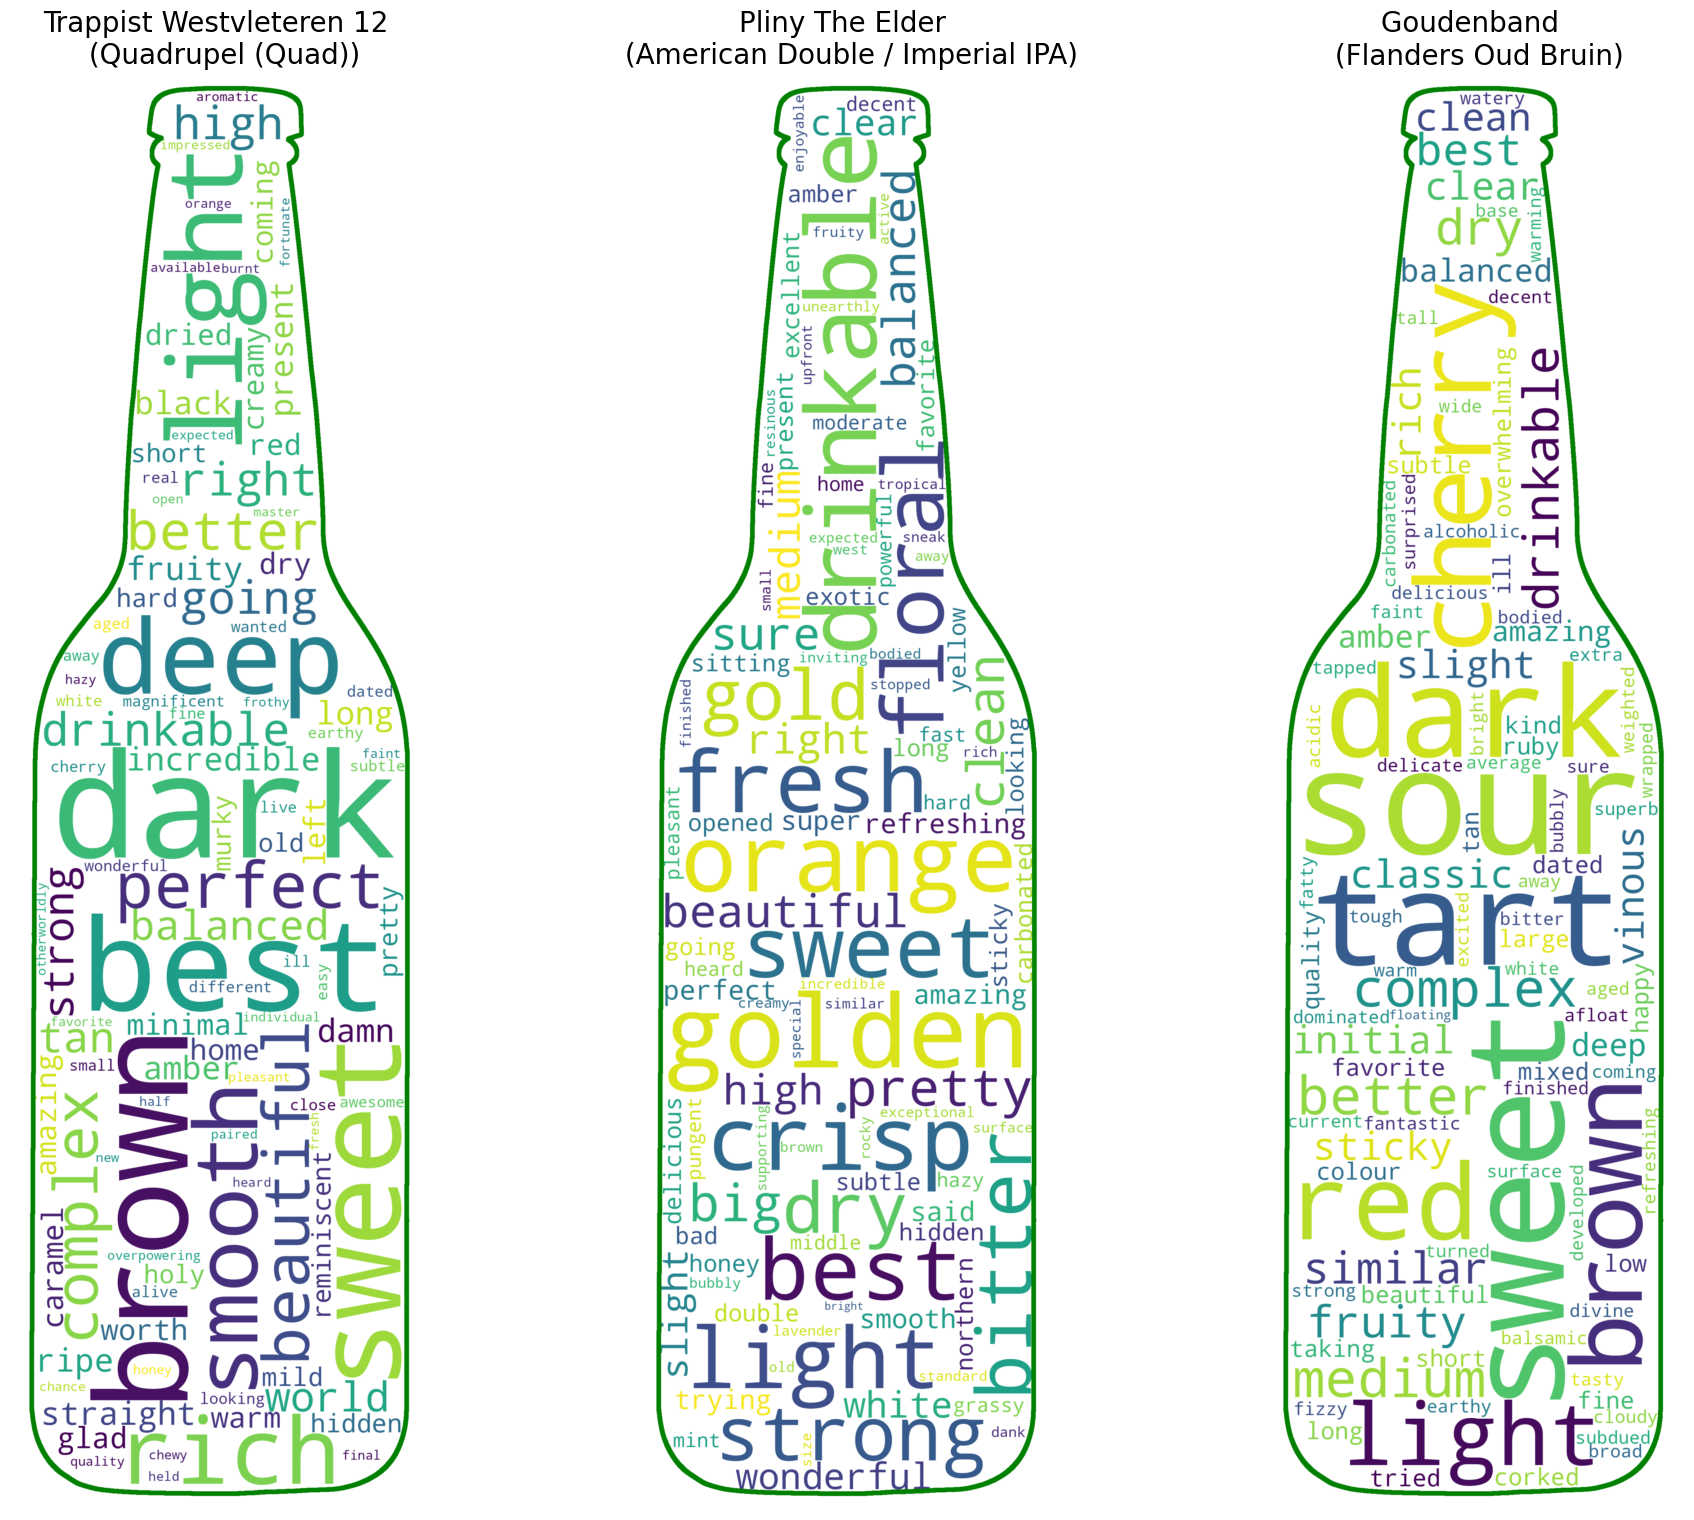

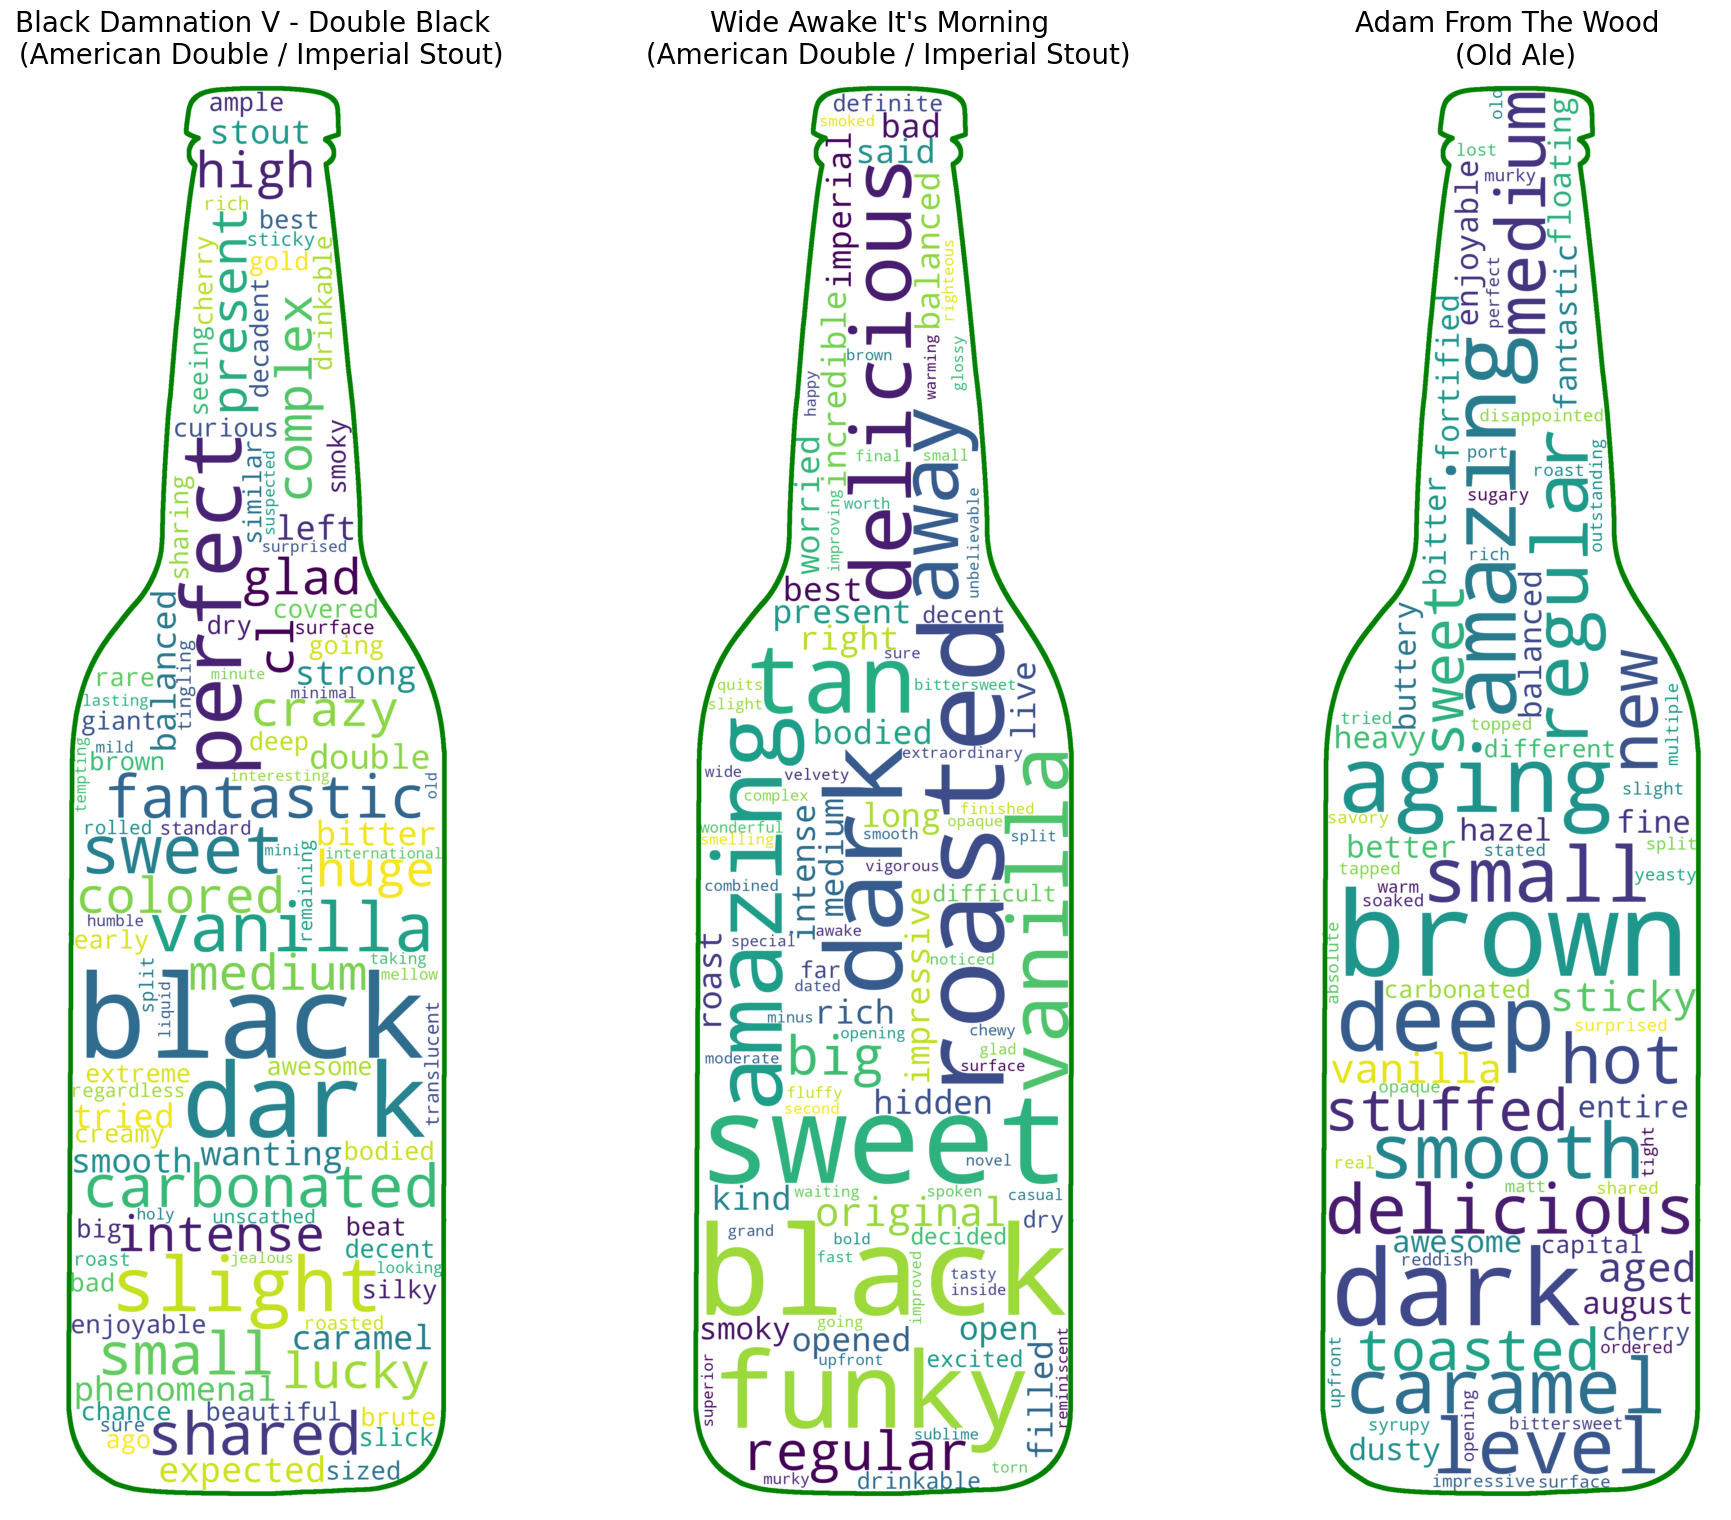

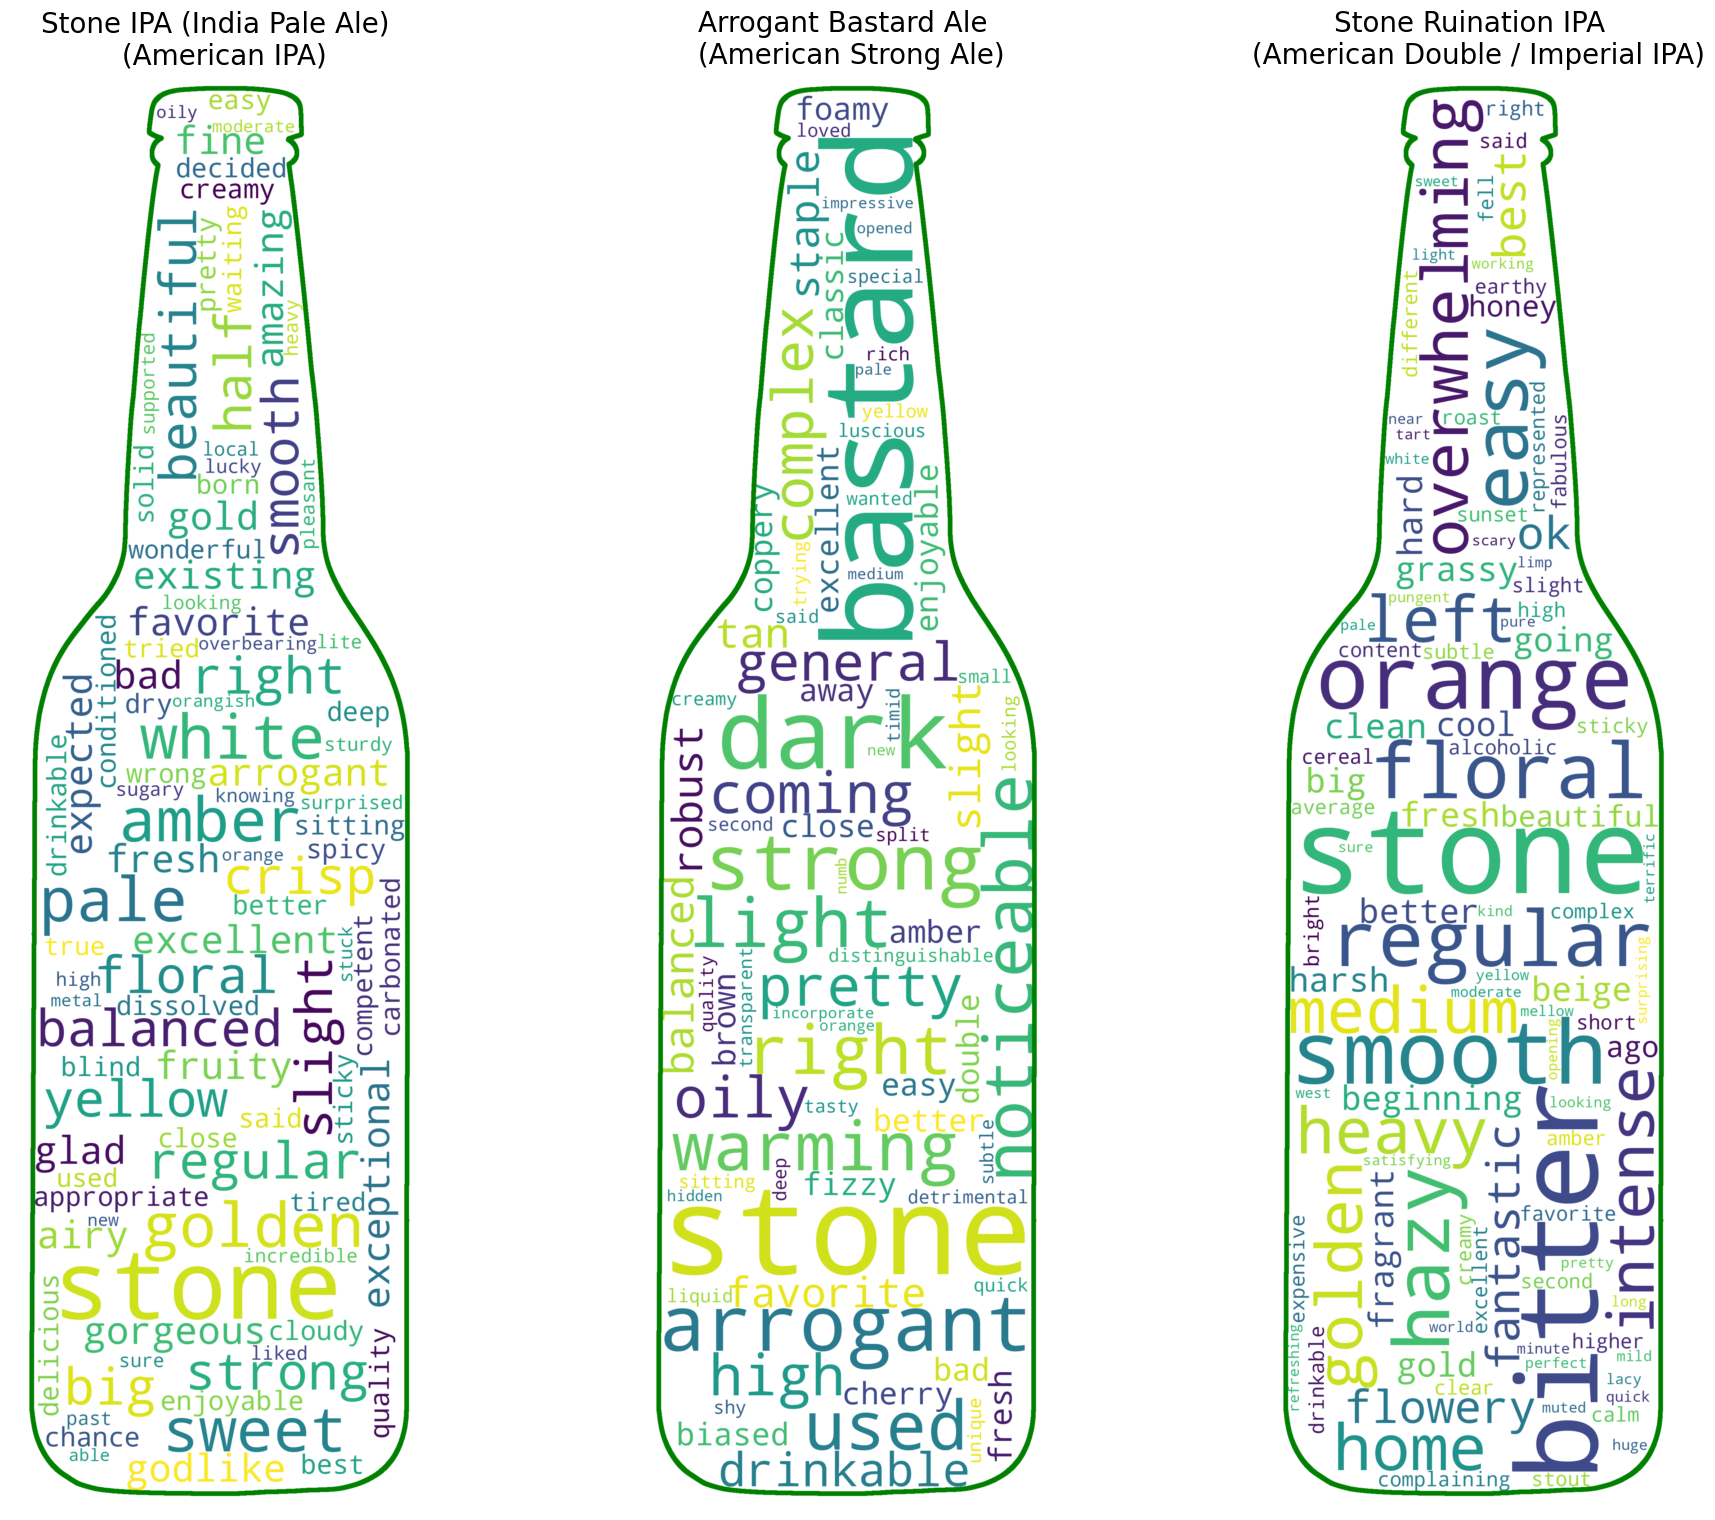

In [ ]:
#generate wordclouds for the top 3 beers in each community

for i, top_beers_com in enumerate(top_beers_by_community):
    fig, ax = plt.subplots(1, 3, figsize=(20, 15))
    for j, beer in enumerate(top_beers_by_community[top_beers_com].index[:3]):
        wc = wordcloud.WordCloud(background_color="white",
                                max_words=100, 
                                mask=beer_mask,
                                contour_color='green',
                                contour_width=25,
                                scale=1)
        wc.generate_from_frequencies(top_beer_tfidf[beer])
        ax[j].imshow(wc, interpolation='bilinear')
        ax[j].axis("off")
        ax[j].imshow(beer_mask, cmap=plt.cm.gray, alpha=0.0)
        #get the name from reviews
        name = reviews[reviews['beer/beerId'] == beer]['beer/name'].iloc[0]
        style = reviews[reviews['beer/beerId'] == beer]['beer/style'].iloc[0]
        #add the beer style to the name
        title = name + ' \n (' + style + ')'
        
        ax[j].set_title(title, fontsize=20, color='black')

    plt.tight_layout(pad=0)
    #save the plot as a png file
    # plt.savefig('wordclouds/community' + str(i) + '.png')

    # plt.close()
    plt.show()


# Discussion

The beer choices within each community provide insights into the distinct preferences and sensibilities of the individuals comprising them. Community 1 exhibits a wide range of beer styles, including both darker and lighter options, suggesting an appreciation for nuanced flavors and varied sensory experiences. Community 2 demonstrates a preference for robust and full-bodied beers, characterized by rich, deep flavors and smooth textures, indicating a fondness for complexity and depth in beer profiles. Community 3 exhibits a preference for fresh and aromatic beers like IPAs, with a focus on bold flavors and refreshing characteristics, suggesting an preference for beers that offer a balance between bitterness and smoothness, with vibrant fruity and floral notes.

Upon examining the word clouds representing all reviews of well-liked beers within each community, it becomes evident that while the communities have slightly different preferences for their top beers, a consistency exists between the preferences in all beers. For instance, descriptors like "sweet" and "smooth" emerge prominently across all communities, suggesting a collective preference for beers with these attributes.

Due to memory limitations, the analysis is carried out on a subset of the data instead of the full dataset. We tried to narrow down the scope by limiting it to users with between 10 and 100 reviews. As such, the presented data will not necessarily be indicative of the full dataset, and the communities will likely look very different.

The generation of these wordclouds rely on review scores, which for people can be highly subjective. Some people may be more inclined to score the beer higher or lower despite having the same oppinion about it, for example a beer rated 3/5 should in theory be average, however due to a leniency bias, some people might rate a beer they percieve as average higher.

The analysis does not consider demographic factors such as age, gender, or geographic location, which could influence beer preferences. Without this information, the findings may not be generalizable to broader populations or demographics. In the wordclouds, we see American beers featured prominently, which may indicate that the majority of the reviewers are American. The beeradvocate forum is in english also, this gates people who don’t speak english to review beers, which introduces a bias.

### Ethical concerns

The data gathered for this analysis is publicly available from beeradvocate.com and only contains usernames. As such, it is anonymized to the extent where a user could have chosen an identifiable username should they have chosen to. In our analysis however, we don't focus on any individual user, but rather communities consisiting of users with similar tastes.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=99ec6d6a-1d83-41bb-83d7-83f6386c0704' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>